In [1]:
#Needed in general


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../Scripts')

#Custom imports
# import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC a


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# print(fs)

import astropy
import seaborn as sns
# from seaborn_utility import cmap_from_colour

from astropy import units as u
from astropy import constants as c

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])



In [2]:
from KDEpy import FFTKDE
from scipy.stats import norm

# Generate a distribution and draw 2**6 data points


In [62]:






def plot_MRR_distribution(axe='None', xparam='chiEff', BPSmodelName='A', mode='pdf',\
                          spin_threshold='None', bw=0.01, xlim=[0,1], ylim=[0,1],\
                          plotYlog='False', ylim_threshold=0.02):#, mssfr='112'):
    
    
    colors = ['#1f77b4', '#ff7f0e']
    colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7)]

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

    del massCO_ZAMSM1
    del massCO_ZAMSM2
    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO


    
    if (mode in ['spin_PDF', 'spin_fraction', 'm1spin_or_m2spin_fraction', 'spin_CDF' ]) | (xparam in ['chi_of_spinning_BH', 'chi_effective', 'log10_t_delay']):
        spin = COspin(data_path=path, state='he_depletion')  # set class 
        spin.setCOMPASData() # reads in the COMPAS DCO parameters 
        spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

        spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
        spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
        spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
        spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

        # spin_threshold = 0.05 # definition of "spinning BH"
        mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) 
        mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # definition of "spinning BH"
        mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )    

    fs_l = 22 # label fontsize

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)

    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
        
    elif xparam=='chi_of_spinning_BH':
        param_x = spinLVKM1 + spinLVKM2

        nameX = r'$\chi_{\rm{BH}}$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,2,1000)  

        
    elif xparam=='chi_effective':
        param_x = ((spinLVKM1*massCO_LVKM1) + (spinLVKM2*massCO_LVKM2)) / (massCO_LVKM1+massCO_LVKM2)
        nameX = r'$\chi_{\rm{eff}}$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,2,1000)          
        
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-4,2,1000)  

    
    if (mode=='MRR_PDF') | (mode=='spin_PDF'):
        nameY = r'\textbf{PDF}'
    elif (mode=='MRR_fraction'):
        nameY = r'$\rm{f}^{\rm{det}}_{\rm{MRR}}$'
    elif (mode=='notMRR_fraction'):
        nameY = r'$\rm{f}^{\rm{det}}_{\rm{non MRR}}$'
    elif (mode=='spin_fraction'):
        nameY =  r'\textbf{fraction}' + '\n' + r'$\chi_{1} > %s$'%spin_threshold
    elif (mode=='m1spin_or_m2spin_fraction'):
        nameY =  r'\textbf{fraction}' + '\n' + r'$\chi_{\rm{BH}} > %s$'%spin_threshold  
    elif (mode=='MRR_CDF') | (mode=='spin_CDF'):
        nameY = r'\textbf{CDF}'
    else:
        raise ValueError("the provided `mode` is not recognized, the value given is %s"%mode)
        
    
    estimator = FFTKDE(kernel='biweight', bw=bw)
    
    if plotYlog==True:       
        axe.set_yscale('log')
    
    for ind_mssfr, mssfr in enumerate(MSSFRnameslist[0:]):
        
        
        
        ls_ = '-'
        Highlight = False
        if ((mssfr in ['123']) & (BPSmodelName in ['A'])):
            ls_ = ':'
            Highlight = True
        elif  ((mssfr in ['312']) & (BPSmodelName in ['T'])):
            ls_ = '--'
            Highlight = True
        elif ((mssfr in ['231']) & (BPSmodelName in ['O'])):
            ls_ = '-.'
            Highlight = True

            
            
        
        ### read in MSSFR weights: ###
        fparam_key = 'weights_detected'
        weightheader = 'w_' + mssfr
        weights_ = fdata[fparam_key][weightheader][...].squeeze()
        w = weights_

        if (mode=='MRR_PDF') | (mode=='MRR_fraction') |  (mode=='notMRR_fraction'): 
            yy_nonMRR = estimator.fit(param_x[~mask_MRR], weights=w[~mask_MRR]).evaluate(xx)
            yy_MRR = estimator.fit(param_x[mask_MRR], weights=w[mask_MRR]).evaluate(xx) 
            
            rel_weight_nonMRR = np.sum(w[~mask_MRR]) / (np.sum(w))
            rel_weight_MRR    = np.sum(w[mask_MRR])  / (np.sum(w))
            yy_nonMRR *= rel_weight_nonMRR
            yy_MRR *= rel_weight_MRR
            
        
        elif (mode=='spin_PDF') | (mode=='spin_fraction'):
            yy_nonMRR = estimator.fit(param_x[mask_LVKM2_spinning], weights=w[mask_LVKM2_spinning]).evaluate(xx)
            yy_MRR = estimator.fit(param_x[mask_LVKM1_spinning], weights=w[mask_LVKM1_spinning]).evaluate(xx)

            rel_weight_nonMRR = np.sum(w[mask_LVKM2_spinning]) / (np.sum(w))
            rel_weight_MRR    = np.sum(w[mask_LVKM1_spinning])  / (np.sum(w))
            yy_nonMRR *= rel_weight_nonMRR
            yy_MRR *= rel_weight_MRR


        ## IF WE ARE PLOTTING CDFs
        elif (mode=='MRR_CDF') | (mode=='spin_CDF'):
            if ((mssfr in ['123']) & (BPSmodelName in ['A'])) | ((mssfr in ['312']) & (BPSmodelName in ['T'])) | ((mssfr in ['231']) & (BPSmodelName in ['O'])):
                axe.hist(param_x[~mask_MRR], bins=10000, color=colors[0], lw=3, zorder=15, alpha=1, ls=ls_ , density=True, weights=weights_[~mask_MRR], cumulative=True, histtype='step')
                axe.hist(param_x[mask_MRR],  bins=10000, color=colors[1], lw=3, zorder=16, alpha=1, ls=ls_,   density=True, weights=weights_[mask_MRR],  cumulative=True, histtype='step')
            else:
                axe.hist(param_x[~mask_MRR], bins=10000, color=colors_lighter[0], lw=1.5, zorder=5, alpha=1, ls=ls_, density=True, weights=weights_[~mask_MRR], cumulative=True, histtype='step')
                axe.hist(param_x[mask_MRR],  bins=10000, color=colors_lighter[1], lw=1.5, zorder=6, alpha=1, ls=ls_,  density=True, weights=weights_[mask_MRR],  cumulative=True, histtype='step')

            axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=5, fontsize=fs_l)                        
                
                
        ### PLOTTING ###
        ## IF WE ARE PLOTTING PDFs
        if (mode=='MRR_PDF') | (mode=='spin_PDF'):
            if Highlight==True:
                axe.plot(xx, yy_nonMRR, color=colors[0], lw=3, zorder=15, alpha=1, ls=ls_)
                axe.plot(xx, yy_MRR,    color=colors[1], lw=3, zorder=16, alpha=1, ls=ls_)
            else:
                axe.plot(xx, yy_nonMRR, color=colors_lighter[0], lw=1.5, zorder=5, alpha=1, ls=ls_)
                axe.plot(xx, yy_MRR,    color=colors_lighter[1], lw=1.5, zorder=6, alpha=1, ls=ls_)
                
            axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=5, fontsize=fs_l)  
            
     
        # PLOTTING FRACTION     
        elif (mode=='MRR_fraction') | (mode=='spin_fraction') | (mode=='notMRR_fraction'):
            
            yy_total = (yy_nonMRR + yy_MRR)
            # in some cases the overall PDF is so small, that the ratio is dominated by some shot noise. So we make those zero. 
            mask_too_small_values = (yy_nonMRR <ylim_threshold) & (yy_MRR < ylim_threshold)
            yy_MRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            yy_nonMRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            
            if (mode=='MRR_fraction') | (mode=='spin_fraction'):
                ratio = yy_MRR/yy_total
                color = colors[1]
                color_lighter = colors_lighter[1]
            elif (mode=='notMRR_fraction'): 
                ratio = yy_nonMRR/yy_total
                color = colors[0]
                color_lighter = colors_lighter[0]
            
            if Highlight==True:
                axe.plot(xx, ratio,     color=color,          lw=3,  zorder=20, alpha=1, ls=ls_)
            else:
                axe.plot(xx, ratio,     color=color_lighter,  lw=1.5, zorder=6, alpha=1, ls=ls_)

            # remove labels and ticks  on X axe
            axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=25, fontsize=fs_l)
            for tick in axe.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)
                         
    
        elif (mode=='m1spin_or_m2spin_fraction'):
            
            yy_total = estimator.fit(param_x, weights=w).evaluate(xx)
            yy_anySpin = estimator.fit(param_x[mask_anySpin], weights=w[mask_anySpin]).evaluate(xx)
           
            
            # in some cases the overall PDF is so small, that the ratio is dominated by some shot noise. So we make those zero. 
            mask_too_small_values = (yy_anySpin < ylim_threshold) & (yy_total < ylim_threshold)
            yy_anySpin[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
            
            if Highlight==True:
                axe.plot(xx, yy_anySpin*np.sum(w[mask_anySpin]) / (yy_total*np.sum(w)),     color='k',        lw=2, zorder=20, alpha=1, ls=ls_)
            else:
                axe.plot(xx, yy_anySpin*np.sum(w[mask_anySpin]) / (yy_total*np.sum(w)),     color='gray',      lw=2, zorder=6, alpha=0.1, ls=ls_)

                    
            # remove labels and ticks  on X axe
            axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=25, fontsize=fs_l)
            for tick in axe.xaxis.get_major_ticks():
                tick.tick1line.set_visible(False)
                tick.tick2line.set_visible(False)
                tick.label1.set_visible(False)
                tick.label2.set_visible(False)



            
    axe.set_xlim(xlim[0], xlim[1])
    axe.set_ylim(ylim[0], ylim[1])
    axe.grid(True)
    

    
    return axe 









# As a function of MRR fraction


### CHIRP MASS 

running model A
running model B
running model C
running model D
running model E
running model F
running model G
running model H
running model I
running model J
running model K
running model L
running model M
running model N
running model O
running model P
running model Q
running model R
running model S
running model T


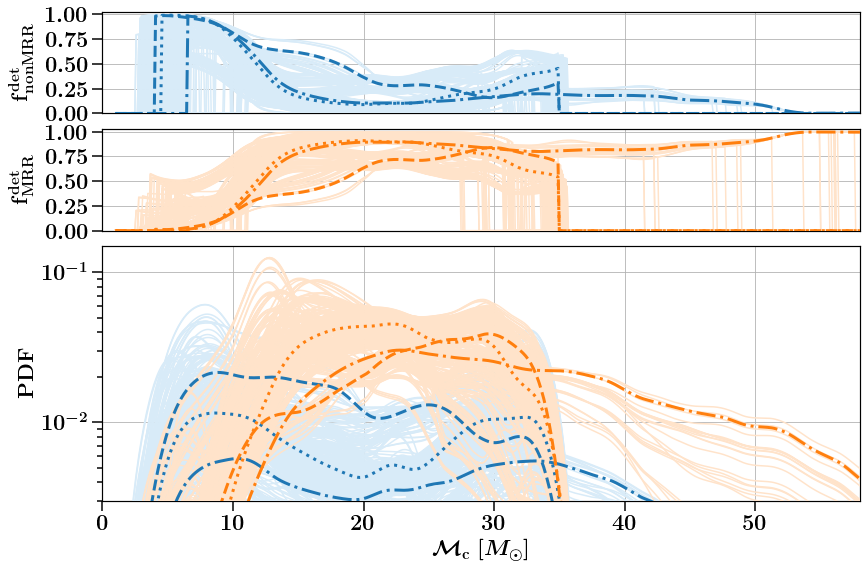

In [65]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1, 1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




bw=0.85
ylim_threshold = 0.004

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):

# for ind_BPS, BPSmodel in enumerate(['A']):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 58], [0.0, 1.03]
    

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='notMRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.003, 0.15]
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0., hspace=0.1)#2)


plt.savefig('./' + xparam    + '_MRR_split_3panel.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam    +  '_MRR_split_3panel.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






### Mass Ratio 

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})



ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A']):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 1], [0.0, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.1, 9.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






### delay time 

running model A
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


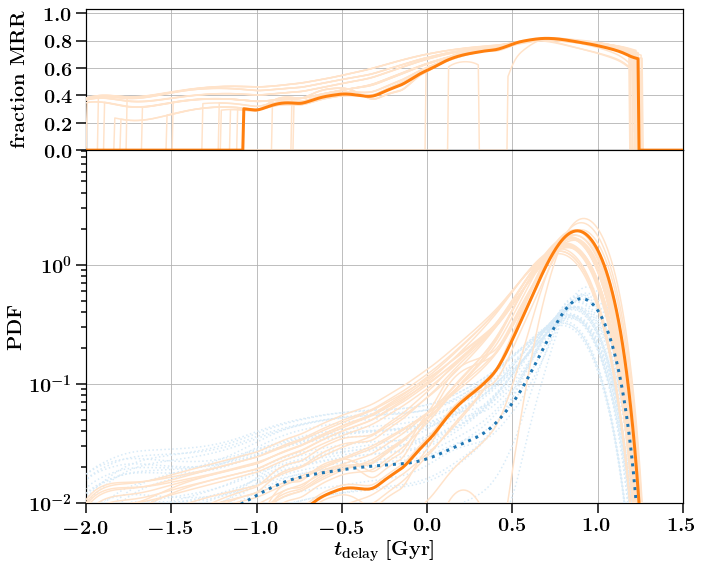

In [26]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})



ylim_threshold = 0.01
bw = 0.09 

# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
for ind_BPS, BPSmodel in enumerate(['A']):
    
    print('running model %s'%BPSmodel)
    xparam = 'log10_t_delay'
    
    plotYlog = False
    xlim, ylim = [-2, 1.5], [0.0, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.01, 9.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






### spin distribution 

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###
fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})

ylim_threshold = 0.01
bw = 0.0051
xparam = 'chi_of_spinning_BH'

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A']):
#     
    print('running model %s'%BPSmodel)

    plotYlog = False
    xlim, ylim = [0.05, 1], [0.0, 1.03] 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = False
    ylim = [0.6, 1.03]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_CDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

# ### CHIRP MASS VS SPINS FRACTION ###
# fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})

# ylim_threshold = 0.01
# bw = 0.0051
# xparam = 'chi_effective'

# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# # for ind_BPS, BPSmodel in enumerate(['A']):
    
#     print('running model %s'%BPSmodel)

#     plotYlog = False
#     xlim, ylim = [0.05, 0.6], [0.0, 1.03] 
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
#     plotYlog = True
#     ylim = [0.01, .715]
#     ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_CDF',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
# plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam   +  '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam   +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
# plt.show()  






## SPLIT UP BY spinning

running model A
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
running model B
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
running model C
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
running model D
0  systems had negative spi

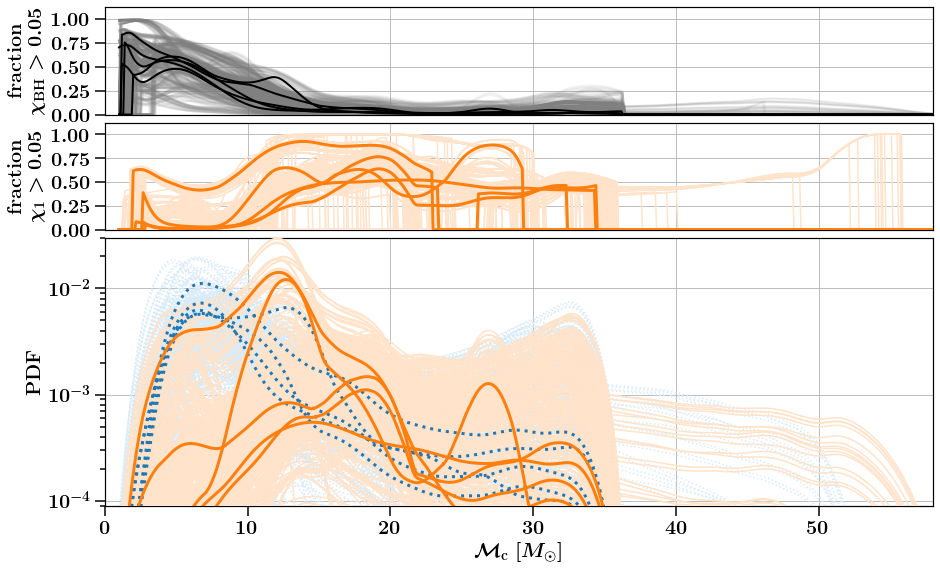

In [15]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(3,1, figsize=(13,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})



bw=0.85
ylim_threshold = 0.00017


for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 58], [0.0, 1.12]
#     xlim, ylim = [0, 40], [0.01, 1]
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.00009, 0.03]
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0.0, hspace=0.05)#2)


plt.savefig('./' + xparam   +  '_spins_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






running model A
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
running model B
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
running model C
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
3  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
running model D
0  systems had negative spi

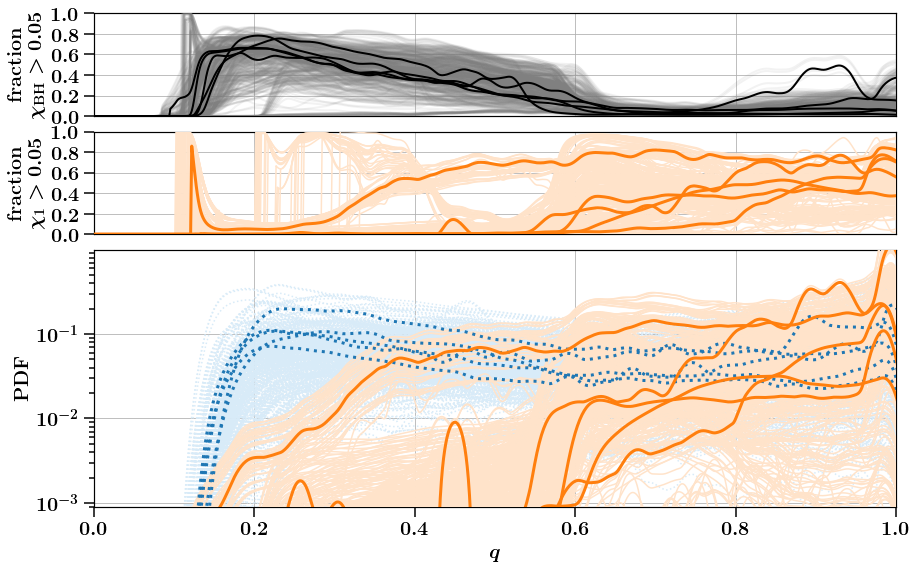

In [16]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(3,1, figsize=(13,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})



bw=0.0085
ylim_threshold = 0.00018


for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate([BPSnameslist[0]]):    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 1], [0.0, 1.0]
#     xlim, ylim = [0, 40], [0.01, 1]
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.0009, 0.99]
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0.0, hspace=0.1)#2)


plt.savefig('./' + xparam   +  '_spins_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






running model A
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 
0  systems had negative spin because they are outside of the boundary conditions; we set these to 0 


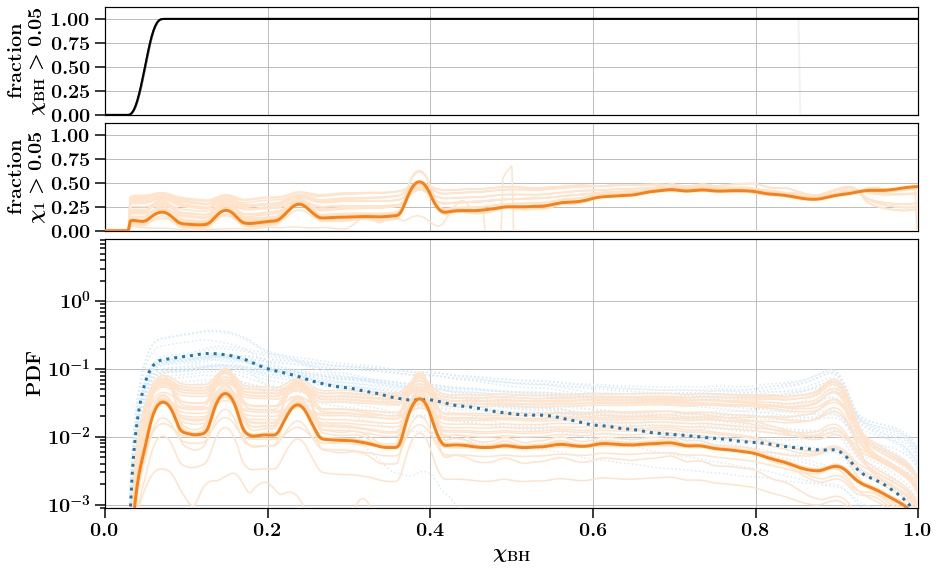

In [18]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(3,1, figsize=(13,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})



bw=0.0085
ylim_threshold = 0.0002


# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:2]):
for ind_BPS, BPSmodel in enumerate([BPSnameslist[0]]):    
    print('running model %s'%BPSmodel)
    xparam = 'chi_of_spinning_BH'
    
    plotYlog = False
    xlim, ylim = [0, 1], [0.0, 1.12]
#     xlim, ylim = [0, 40], [0.01, 1]
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.0009, 8.3]
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0.0, hspace=0.05)#2)


plt.savefig('./' + xparam   +  '_spins_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

# ### CHIRP MASS VS SPINS FRACTION ###


# fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
# #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




# bw=0.85
# ylim_threshold = 0.004

# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):

# # for ind_BPS, BPSmodel in enumerate(['A']):
    
#     print('running model %s'%BPSmodel)
#     xparam = 'chirp_mass_LVK'
    
#     plotYlog = False
#     xlim, ylim = [0, 58], [0.0, 1.03]
    
# #     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
# #                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
#     plotYlog = True
#     ylim = [0.003, 0.15]
#     ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
# plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam    + '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam    +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
# plt.show()  






In [ ]:






def plot_Fig_GWTC(axe='None', xparam='chiEff', BPSmodelName='A', mssfr='112', spin_threshold=0.05, hack=None):
    
    colors = ['#1f77b4', '#ff7f0e']
    colors_lighter = [adjust_lightness(color=colors[0], amount=2.2),adjust_lightness(color=colors[1], amount=1.7)]

    DCOtype='BBH'
    # path for files 
    path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    fdata = h5.File(path, 'r')
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    seedsDCO  = fdata['doubleCompactObjects']['seed'][...].squeeze()  # get the seeds in the DCO file 
    seedsSN   = fdata['supernovae']['randomSeed'][...].squeeze()    # get the seeds in the SN file 
    indices   = np.sort(np.unique(seedsSN[1::2], return_index=True)[1])
    maskSNdco = np.in1d(seedsSN,  seedsDCO) # mask in the SNe files the SNe that correspond to our DCO
    whichSN   = fdata['supernovae']['whichStar'][...].squeeze()[maskSNdco]  # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova     
    whichSN2  = whichSN[1::2][indices]

    # either SN2 = primary (1) and M1 is > M2, or SN2 = secondary & M1 < M2 
    # this takes into account (first term) rejuvenation 
    mask_MRR = ((whichSN2==1) & (massCO_ZAMSM1>massCO_ZAMSM2) ) | ((whichSN2==2) & (massCO_ZAMSM1<massCO_ZAMSM2)) 

#     del massCO_ZAMSM1
#     del massCO_ZAMSM2
    del whichSN2
    del whichSN
    del maskSNdco
    del indices
    del seedsSN
    del seedsDCO


    spin = COspin(data_path=path, state='he_depletion')  # set class 
    spin.setCOMPASData() # reads in the COMPAS DCO parameters 
    spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 

    spinLVKM1, spinLVKM2 = np.zeros_like(spinZAMSM1), np.zeros_like(spinZAMSM1)
    spinLVKM1[mask_MRR] = spinZAMSM2[mask_MRR]  # MRR so M1 comes from M2ZAMS, we assign it spin from M2ZAMS
    spinLVKM1[~mask_MRR] = spinZAMSM1[~mask_MRR]  # no MRR so M1 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[mask_MRR] = spinZAMSM1[mask_MRR]   # MRR so M2 comes from M1ZAMS, we assign it spin from M1ZAMS
    spinLVKM2[~mask_MRR] = spinZAMSM2[~mask_MRR]   # no MRR so M2 comes from M2ZAMS, we assign it spin from M2ZAMS     

    # spin_threshold = 0.05 # definition of "spinning BH"
    mask_LVKM1_spinning = (spinLVKM1 > spin_threshold ) 
    mask_LVKM2_spinning = (spinLVKM2 > spin_threshold ) # definition of "spinning BH"
    mask_anySpin = (spinLVKM1 > spin_threshold ) | (spinLVKM2 > spin_threshold )    

    print('\t non-zero spin:', np.sum(mask_anySpin), 'out of ', len(mask_anySpin), 'BBHs')

    
    ### read in MSSFR weights: ###
    fparam_key = 'weights_detected'
    weightheader = 'w_' + mssfr
    weights_ = fdata[fparam_key][weightheader][...].squeeze()
    w = weights_
    
    fs_l = 20 # label fontsize
    


    if xparam=='ChiEff_vs_q':
        axe.set_xlim(-0.06, 1.05)
        axe.set_ylim(0, 1)  
        chi_eff = ((spinZAMSM1 * massCO_ZAMSM1) + spinZAMSM2 * massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
        param_x = chi_eff
        param_y = MassRatioCO_LVK
        nameX = r'$\chi_{\rm{eff}}$'
        nameY = r'$q$'
 
        
    NN_ = 100
    mask_nonZero = (chi_eff>0.1)
    print(chi_eff[mask_nonZero])
    size_ = 500
    
    
    if hack=='chi_eff':
        axe.hist(param_x[~mask_MRR][:], bins=100, color=colors_lighter[0], weights=w[~mask_MRR][:], zorder=1, label=r'no MRR', density=True, histtype='step') # all non MRR 
        axe.hist(param_x[mask_MRR][:],  bins=100, color=colors[1],         weights=w[mask_MRR][:],  zorder=2, label=r'MRR: $q < 1$', density=True, histtype='step') # all non MRR 
        
    elif hack=='q':
        axe.hist(param_y[~mask_MRR][:NN_], bins=100, color=colors_lighter[0], weights=w[~mask_MRR][:NN_], zorder=1, label=r'no MRR', density=True, histtype='step') # all non MRR 
        axe.hist(param_y[mask_MRR][:NN_],  bins=100, color=colors[1],         weights=w[mask_MRR][:NN_],  zorder=2, label=r'MRR: $q < 1$', density=True, histtype='step') # all non MRR 
        
    
    else:
#         axe.scatter(param_x[~mask_MRR][:NN_], param_y[~mask_MRR][:NN_], s=size_*w[~mask_MRR][:NN_], color=colors_lighter[0], zorder=1, label=r'no MRR') # all non MRR 
#         axe.scatter(param_x[mask_MRR][:NN_], param_y[mask_MRR][:NN_], s=size_*w[mask_MRR][:NN_], color=colors[1], zorder=2, label=r'MRR: $q < 1$') # all non MRR 
        axe.scatter(param_x[~mask_MRR][:], param_y[~mask_MRR][:], s=size_*w[~mask_MRR][:], color=colors_lighter[0], zorder=1, label=r'no MRR') # all non MRR 
        axe.scatter(param_x[mask_MRR][:], param_y[mask_MRR][:], s=size_*w[mask_MRR][:], color=colors[1], zorder=2, label=r'MRR') # all non MRR 


    axe.grid(True)
    
    if BPSmodelName=='A':
        axe = layoutAxes(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)
    else:
        axe = layoutAxesNoYlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)

        for tick in axe.yaxis.get_major_ticks():
            tick.tick1line.set_visible(False)
            tick.tick2line.set_visible(False)
            tick.label1.set_visible(False)
            tick.label2.set_visible(False)


    
    
    axe.text(0+0.009, 0.009, r'\textbf{model %s} %s'%(BPSmodelName,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs-2, color = 'k', ha = 'left', va='bottom', transform=axe.transAxes, zorder=100)#, weight = 'bold')
    
#     plt.legend(fontsize=fs_l, loc=3)
    
    
  
    
    return axe 









In [ ]:



fig, ax = plt.subplots(1,5, figsize=(28,6))#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
xparam='ChiEff_vs_q'

# for ax_ind, model in enumerate(['A', 'G', 'J', 'K', 'R']):
for ax_ind, model in enumerate([ 'K']):
    ax[ax_ind] = plot_Fig_GWTC(axe=ax[ax_ind], xparam='ChiEff_vs_q', BPSmodelName=model, mssfr=mssfr)
    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam + '_' + mssfr   +  '.png', transparent=False, bbox_inches="tight", dpi=300)
plt.show()  

## as a split up of chi 

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate([BPSnameslist[0]]):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 40], [0.01, 1]
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    plotYlog = True
    ylim = [0.001, 0.03]
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_spins_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

# ### CHIRP MASS VS SPINS FRACTION ###

# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
#     for ind_mssfr, mssfr in enumerate(MSSFRlist):
#         fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#         #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})
#         bw=0.85
#         ylim_threshold = 0.02


#         # for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):

#             print('running model %s'%BPSmodel)
#             xparam = 'chirp_mass_LVK'

#             plotYlog = False
#             xlim, ylim = [0, 58], [0.0, 1.03]

#         #     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#         #                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
#             ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
#                                           spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold, mssfr=mssfr) 
#             plotYlog = True
#             ylim = [0.002, 0.15]
#             ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
#                                           spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold, mssfr=mssfr)


#         plt.tight_layout()  
#         plt.subplots_adjust(wspace=0, hspace=0)#2)


#         plt.savefig('./standout/' + xparam  + mssfr  +  '_MRR_split.pdf', transparent=False, bbox_inches="tight",  format='pdf')
#         plt.savefig('./standout/' + xparam  + mssfr  +  '_MRR_split.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
#         # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
#         plt.show() 
#         plt.close()






In [ ]:

# ### CHIRP MASS VS SPINS FRACTION ###


# fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
# #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




# bw=0.85
# ylim_threshold = 0.01

# for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# # for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
#     print('running model %s'%BPSmodel)
#     xparam = 'chirp_mass_LVK'
    
#     plotYlog = True
#     xlim, ylim = [0, 58], [0.04, 1.03]
    
# #     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
# #                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
#     plotYlog = True
#     ylim = [0.002, 0.15]
#     ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
#                                   spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
# plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam   +  '_MRR_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam   +  '_MRR_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
# plt.show()  






### mass ratio

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 1], [0.0, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = False
    ylim = [0., 6.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = True
    xlim, ylim = [0, 1], [0.04, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.1, 9.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






### Spin of Spinning BH 

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.011
xparam = 'chi_of_spinning_BH'

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    
    
    plotYlog = True
    xlim, ylim = [0, 1], [0.04, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = True
    ylim = [0.01, 18.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate([BPSnameslist[0]]):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 40], [0.01, 1]
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    plotYlog = True
    ylim = [0.001, 0.03]
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',\
                                  spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_spins_log_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_log_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate([BPSnameslist[0]]):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05, bw=0.04) 
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05, bw=0.04)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam   +  '_spins_log.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam   +  '_spins_log.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
    
    print('running model %s'%BPSmodel)
    xparam = 'chirp_mass_LVK'

#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction', spin_threshold=0.05, bw=0.24) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',      spin_threshold=0.05, bw=0.24)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






# Chi fraction 

In [ ]:

### CHIRP MASS VS SPINS FRACTION ###


fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'

ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:]):
# for ind_BPS, BPSmodel in enumerate(['A', 'B', 'K', 'S', 'T']):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = False
    xlim, ylim = [0, 1], [0.0, 1.03]
    
#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction',\
#                                   spin_threshold=0.05, bw=0.85, xlim=xlim, ylim=ylim, plotYlog=plotYlog) 
    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold) 
    plotYlog = False
    ylim = [0., 6.15]
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_PDF',\
                                  spin_threshold=0.05, bw=bw, xlim=xlim, ylim=ylim, plotYlog=plotYlog, ylim_threshold=ylim_threshold)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_MRR_NoTlog_temp.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




ylim_threshold = 0.01
bw = 0.01 

for ind_BPS, BPSmodel in enumerate(BPSnameslist[:2]):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    
    plotYlog = True
    xlim, ylim = [0, 1], [0.0, 1.03]
    

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05, bw=0.04) 
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05, bw=0.04)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_spins_log_2.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins_log_2.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:





mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate(BPSnameslist[:2]):
    fig, ax = plt.subplots(3,1, figsize=(12,8), gridspec_kw={"height_ratios":[1,1, 2.5]})#,\
    #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='m1spin_or_m2spin_fraction', spin_threshold=0.05, bw=0.01) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05, bw=0.04) 
    ax[2] = plot_MRR_distribution(axe=ax[2], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05, bw=0.04)

    
    plt.tight_layout()  
    plt.subplots_adjust(wspace=0, hspace=0)#2)


#     plt.savefig('./' + xparam   +  '_spins_log_' + BPSmodel + '.pdf', transparent=False, bbox_inches="tight",  format='pdf')
#     plt.savefig('./' + xparam   +  '_spins_log_' + BPSmodel + '.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
    # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
    plt.show()  






In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8), gridspec_kw={"height_ratios":[1, 2.5]})#,\
#                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




mssfr = '112' # mssfr that matches LIGO observed rates.
# xparam='ChiEff'
model='A'


for ind_BPS, BPSmodel in enumerate(BPSnameslist[0:]):
    
    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'

    ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_fraction', spin_threshold=0.05) 
    ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='spin_PDF',      spin_threshold=0.05)

    
plt.tight_layout()  
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./' + xparam   +  '_spins.pdf', transparent=False, bbox_inches="tight",  format='pdf')
plt.savefig('./' + xparam   +  '_spins.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
plt.show()  






In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(8,8))#,\
# #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




# mssfr = '112' # mssfr that matches LIGO observed rates.
# # xparam='ChiEff'
# model='A'


# for ind_BPS, BPSmodel in enumerate(BPSnameslist):
#     print('running model %s'%BPSmodel)
#     # for ax_ind, model in enumerate(['A', 'G', 'J', 'K', 'R']):
#     xparam = 'mass_ratio_LVK'
#     ax = plot_PDF(axe=ax, xparam=xparam, BPSmodelName=BPSmodel) #, mssfr=None)

    
# plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./' + xparam   +  '.eps', transparent=False, bbox_inches="tight", dpi=600, format='eps')
# plt.show()  

In [ ]:






# def plot_fraction(axe='None', xparam='chiEff', BPSmodelName='A'):#, mssfr='112'):
    
# #     labellist= np.ones(5) #,  r'$\log_{10}(t) $']      

#     DCOtype='BBH'
#     # path for files 
#     path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
#     path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    
    
#     # read in data 
#     fdata = h5.File(path)
    
#     massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
#     massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
#     # M1 will be the most massive, M2 the least massive compact object. 
#     massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
#     MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1


        
# #     spin = COspin(data_path=path, state='he_depletion')  # set class 
# #     spin.setCOMPASData() # reads in the COMPAS DCO parameters 
# #     spinZAMSM1, spinZAMSM2  = spin.BaveraSpin() #ZAMS M1 SPIN 
    
    
# #     maxSpinBBH = np.maximum(spinZAMSM1,spinZAMSM2)
# #     mask_ = (maxSpinBBH >0)
# #     print('\t non-zero spin:', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
# #     mask_ = (maxSpinBBH >0.2)
# #     print('\t a spin >.2: ', np.sum(mask_), 'out of ', len(mask_), 'BBHs')
    
#     mask_MRR = (massCO_ZAMSM1/massCO_ZAMSM2) < 1



#     fs_l = 20 # label fontsize

#     if xparam=='ChiEff_vs_q':
#         axe.set_xlim(-0.06, 1.05)
#         axe.set_ylim(0, 1)  
#         chi_eff = ((spinZAMSM1 *massCO_ZAMSM1) + spinZAMSM2*massCO_ZAMSM2) / (massCO_ZAMSM1+massCO_ZAMSM2)
#         param_x = chi_eff
#         param_y = MassRatioCO_LVK
#         nameX = r'$\chi_{\rm{eff}}$'
#         nameY = r'$q$'

#     if xparam=='mass_ratio_LVK':
#         param_x = MassRatioCO_LVK
#         nameX = r'$q$'
#         nameY = r'\textbf{fraction MRR}'
#         xx = np.linspace(-0.2,1.2,1000)
#         axe.set_xlim(0,1)
        

#     COLOR=False   
#     for ind_mssfr, mssfr in enumerate(MSSFRnameslist):
#         ### read in MSSFR weights: ###
#         fparam_key = 'weights_detected'
#         weightheader = 'w_' + mssfr
#         weights_ = fdata[fparam_key][weightheader][...].squeeze()
#         w = weights_
#         w_total = np.sum(w)

#         estimator = FFTKDE(kernel='biweight', bw=0.01)
        
#         yy_nonMRR = estimator.fit(param_x[~mask_MRR], weights=w[~mask_MRR]).evaluate(xx) * np.sum(w[~mask_MRR])/w_total
#         yy_MRR = estimator.fit(param_x[mask_MRR], weights=w[mask_MRR]).evaluate(xx)  * np.sum(w[mask_MRR])/w_total 
# #         print('should be 1 : ', (np.sum(yy_nonMRR)+ np.sum(yy_MRR)))
#         yy_total = (yy_nonMRR + yy_MRR)
    
#         # in some cases the non MRR is so small, that the ratio is dominated by some shot noise in MRR. So we make those zero. 
#         mask_too_small_values = (yy_nonMRR < 10**(-4))
#         yy_MRR[mask_too_small_values] = np.zeros(int(np.sum(mask_too_small_values)))
        
#         if (mssfr in ['312', '231']) & (BPSmodelName in ['A', 'B', 'K', 'S', 'T']):
#             axe.plot(xx, yy_MRR/yy_total,    label='MRR',     color='crimson',        lw=2, zorder=20, alpha=1)
#         else:
#             axe.plot(xx, yy_MRR/yy_total,    label='MRR',     color='k',        lw=2, zorder=6, alpha=0.1)
            

#     axe.grid(True)
    
# #     if BPSmodelName=='A':
#     axe = layoutAxesNoXlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=15, fontsize=fs_l)
# #     else:
# #         axe = layoutAxesNoYlabel(axe, nameX=nameX, nameY=nameY, setMinor=False, labelpad=10, fontsize=fs_l)

#     for tick in axe.xaxis.get_major_ticks():
#         tick.tick1line.set_visible(False)
#         tick.tick2line.set_visible(False)
#         tick.label1.set_visible(False)
#         tick.label2.set_visible(False)


    
    
# #     axe.text(0+0.009, 0.009, r'\textbf{model %s} %s'%(BPSmodelName,alphabetPhysicalNameDict[BPSmodelName]) , rotation = 0, fontsize = fs-2, color = 'k', ha = 'left', va='bottom', transform=axe.transAxes, zorder=100)#, weight = 'bold')
    
# #     plt.legend(fontsize=fs_l, loc=3)
    
    
  
    
#     return axe 









In [ ]:
# fig, ax = plt.subplots(2,1, figsize=(10,10), gridspec_kw={"height_ratios":[1, 3]})#,\
# #                            gridspec_kw={"width_ratios":[3, 3, 3, 3, 3]})




# mssfr = '112' # mssfr that matches LIGO observed rates.
# # xparam='ChiEff'
# model='A'


# for ind_BPS, BPSmodel in enumerate(BPSnameslist[0:]):
    
#     print('running model %s'%BPSmodel)
#     xparam = 'mass_ratio_LVK'

#     ax[0] = plot_MRR_distribution(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel, mode='MRR_fraction') 
#     ax[1] = plot_MRR_distribution(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel, mode='pdf')

    
# # plt.tight_layout()  
# plt.subplots_adjust(wspace=0, hspace=0)#2)

# plt.savefig('./' + xparam   +  'fraction.pdf', transparent=False, bbox_inches="tight",  format='pdf')
# plt.savefig('./' + xparam   +  'fraction.png', transparent=False, bbox_inches="tight", dpi=600, format='png')
# # plt.savefig('./' + xparam   +  'fraction.eps', bbox_inches="tight", dpi=600, format='eps')
# plt.show()  

In [ ]:



for ind_BPS, BPSmodel in enumerate(BPSnameslist[0:]):
    
    
    
    
    fig, ax = plt.subplots(2,1, figsize=(10,10), gridspec_kw={"height_ratios":[1, 3]})#,\

    print('running model %s'%BPSmodel)
    xparam = 'mass_ratio_LVK'
    ax[1] = plot_PDF(axe=ax[1], xparam=xparam, BPSmodelName=BPSmodel) #, mssfr=None)
    ax[0] = plot_fraction(axe=ax[0], xparam=xparam, BPSmodelName=BPSmodel) #, mssfr=None)

    
    # plt.tight_layout()  
    plt.subplots_adjust(wspace=0, hspace=0)#2)


    # plt.savefig('./' + xparam   +  'fraction.eps', transparent=False, bbox_inches="tight", dpi=600, format='eps')
    plt.show()  